In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import json
import deepinv as dinv
from skimage.transform import iradon
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from itertools import repeat
import odl
from odl.phantom import ellipsoid_phantom
from odl import uniform_discr


/home/ktaghavi/miniconda3/envs/msc_dip_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from typing import Tuple, Union, Iterator
from itertools import repeat

class EllipsesDataset(torch.utils.data.IterableDataset):
    """
    Dataset with images of multiple random ellipses.
    This dataset uses :meth:`odl.phantom.ellipsoid_phantom` to create
    the images. The images are normalized to have a value range of ``[0., 1.]`` with a
    background value of ``0.``.
    """

    def __init__(
        self,
        shape: Tuple[int, int] = (128, 128),
        length: int = 3200,
        fixed_seed: int = 1,
        fold: str = "train",
        max_n_ellipse: int = 70,
    ):
        self.shape = shape
        min_pt = [-self.shape[0] / 2, -self.shape[1] / 2]
        max_pt = [self.shape[0] / 2, self.shape[1] / 2]
        self.space = uniform_discr(min_pt, max_pt, self.shape)
        self.length = length
        self.max_n_ellipse = max_n_ellipse
        self.ellipses_data = []
        self.setup_fold(fixed_seed=fixed_seed, fold=fold)
        super().__init__()

    def setup_fold(self, fixed_seed: int = 1, fold: str = "train"):
        fixed_seed = None if fixed_seed in [False, None] else int(fixed_seed)
        if (fixed_seed is not None) and (fold == "validation"):
            fixed_seed = fixed_seed + 1
        self.rng = np.random.RandomState(fixed_seed)

    def __len__(self) -> Union[int, float]:
        return self.length if self.length is not None else float("inf")

    def _extend_ellipses_data(self, min_length: int) -> None:
        ellipsoids = np.empty((self.max_n_ellipse, 6))
        n_to_generate = max(min_length - len(self.ellipses_data), 0)
        for _ in range(n_to_generate):
            v = self.rng.uniform(-0.4, 1.0, (self.max_n_ellipse,))
            a1 = 0.2 * self.rng.exponential(1.0, (self.max_n_ellipse,))
            a2 = 0.2 * self.rng.exponential(1.0, (self.max_n_ellipse,))
            x = self.rng.uniform(-0.9, 0.9, (self.max_n_ellipse,))
            y = self.rng.uniform(-0.9, 0.9, (self.max_n_ellipse,))
            rot = self.rng.uniform(0.0, 2 * np.pi, (self.max_n_ellipse,))
            n_ellipse = min(self.rng.poisson(self.max_n_ellipse), self.max_n_ellipse)
            v[n_ellipse:] = 0.0
            ellipsoids = np.stack((v, a1, a2, x, y, rot), axis=1)
            self.ellipses_data.append(ellipsoids)

    def _generate_item(self, idx: int) -> Tensor:
        ellipsoids = self.ellipses_data[idx]
        image = ellipsoid_phantom(self.space, ellipsoids)
        # normalize the foreground (all non-zero pixels) to [0., 1.]
        image[np.array(image) != 0.0] -= np.min(image)
        image /= np.max(image)

        return torch.from_numpy(image.asarray()[None]).float()  # add channel dim

    def __iter__(self) -> Iterator[Tensor]:
        it = repeat(None, self.length) if self.length is not None else repeat(None)
        for idx, _ in enumerate(it):
            self._extend_ellipses_data(idx + 1)
            yield self._generate_item(idx)

    def __getitem__(self, idx: int) -> Tensor:
        self._extend_ellipses_data(idx + 1)
        return self._generate_item(idx)

def get_ellipses_dataset(
    fold: str = "train",
    im_size: int = 128,
    length: int = 3200,
    max_n_ellipse: int = 70,
    fixed_seed: int = 1,
    device=None,
) -> EllipsesDataset:
    image_dataset = EllipsesDataset(
        (im_size, im_size), length=length, fold=fold, max_n_ellipse=max_n_ellipse
    )

    return image_dataset

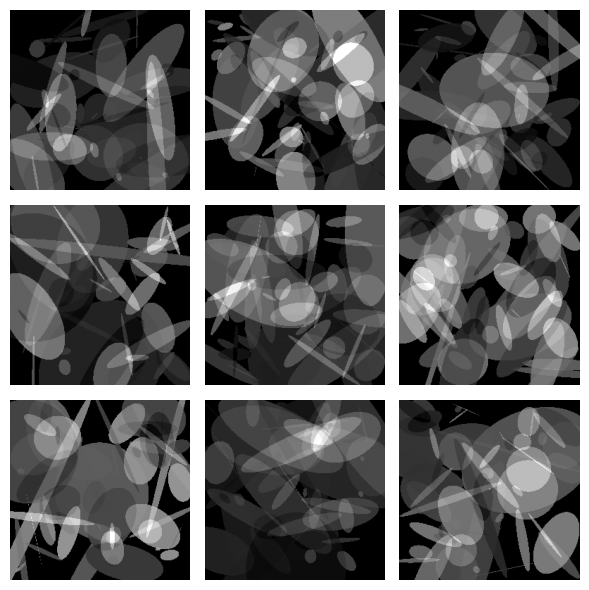

In [5]:
ds = get_ellipses_dataset(fold="train", im_size = 256, length = 5000, max_n_ellipse = 70)

# 2) Grab the first N images
imgs = []
for i in range(9):
    img = ds[i]             # this is a torch tensor [1,H,W]
    imgs.append(img.squeeze(0).numpy())

# 3) Plot them in a 3×3 grid
fig, axs = plt.subplots(3, 3, figsize=(6,6))
for ax, im in zip(axs.flat, imgs):
    ax.imshow(im, cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [6]:
def save_img(out_put_tensor, epoch, out_dir="outputs"):
  """
  Save the image output at each epoch
  """
  img = out_put_tensor.squeeze().detach.cpu().numpy()

  os.makedirs(out_dir, exist_ok = True)
  name = f"output_{epoch}"
  plt.imsave(os.path.join(out_dir, name), img, cmap="gray", vmin=0, vmax=1)

In [ ]:
# Import UNet file
sys.path.append('/content/drive/MyDrive/MScProject')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The device used is {device}")

from Model_arch import UNet


# Import Elipses Data
train_ds = get_ellipses_dataset(fold="train", im_size = 256, length = 5000, max_n_ellipse = 40, fixed_seed= 42)
test_ds  = get_ellipses_dataset(fold="validation", im_size = 256, length = 1000, max_n_ellipse = 40, fixed_seed= 1)

train_loader = DataLoader(train_ds, batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=16)

In [8]:
class OperatorFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, operator, x):
        # ctx.operator saved for backward
        ctx.operator = operator
        # call the DeepInv forward operator A
        with torch.no_grad():
            out = operator.A(x)
        # no need to save x unless A is nonlinear
        return out

    @staticmethod
    def backward(ctx, grad_output):
        # in the backward pass, apply the adjoint A_adjoint
        operator = ctx.operator
        grad_input = operator.A_adjoint(grad_output)
        # first returned None says “no gradient for operator”
        return None, grad_input

class OperatorModule(torch.nn.Module):
    def __init__(self, operator):
        super().__init__()
        self.operator = operator

    def forward(self, x):
        # call our custom Function
        return OperatorFunction.apply(self.operator, x)

    def A_dagger(self, y):
        # if you ever want to call the adjoint directly
        return self.operator.A_dagger(y)

In [9]:
angles_torch = torch.linspace(0,180,60,device=device)

angles_torch = torch.linspace(0,180,60,device=device)
physics_raw = dinv.physics.Tomography(
    img_width=256, angles=angles_torch, device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=0.02)
)

physics = OperatorModule(physics_raw)

In [10]:
pre_model = UNet(1, 1)
pre_model = pre_model.to(device)
opt = torch.optim.Adam(pre_model.parameters(), lr = 1e-4)

Epoch 00 train Loss: 0.0067
Best model saved at epoch 0


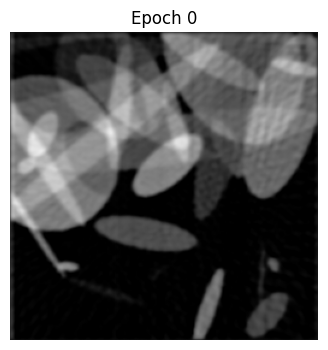

Epoch 00 test  Loss: 0.0020
Epoch 01 train Loss: 0.0018
Best model saved at epoch 1


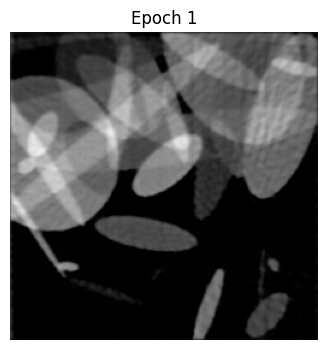

Epoch 01 test  Loss: 0.0016
Epoch 02 train Loss: 0.0015
Best model saved at epoch 2


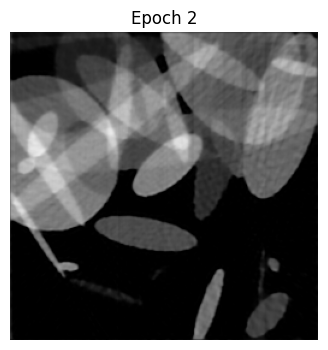

Epoch 02 test  Loss: 0.0013
Epoch 03 train Loss: 0.0012
Best model saved at epoch 3


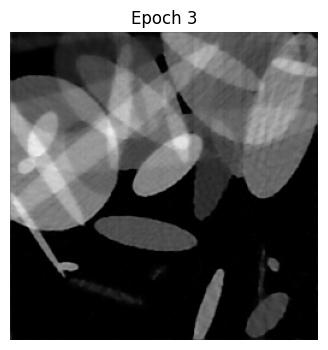

Epoch 03 test  Loss: 0.0011
Epoch 04 train Loss: 0.0011
Best model saved at epoch 4


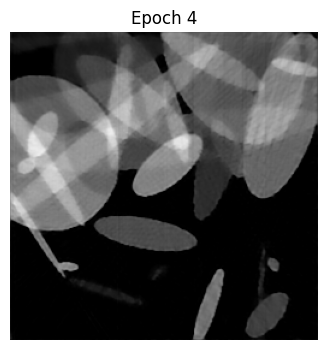

Epoch 04 test  Loss: 0.0010
Epoch 05 train Loss: 0.0010
Best model saved at epoch 5


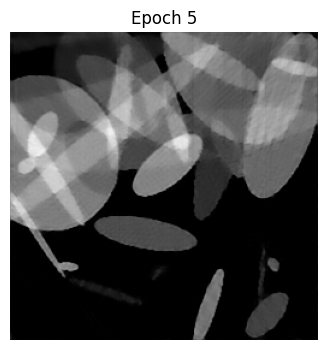

Epoch 05 test  Loss: 0.0009
Epoch 06 train Loss: 0.0009
Best model saved at epoch 6


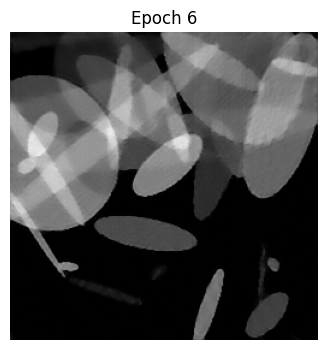

Epoch 06 test  Loss: 0.0008
Epoch 07 train Loss: 0.0008
Best model saved at epoch 7


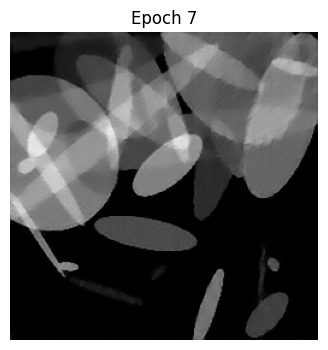

Epoch 07 test  Loss: 0.0008
Epoch 08 train Loss: 0.0008
Best model saved at epoch 8


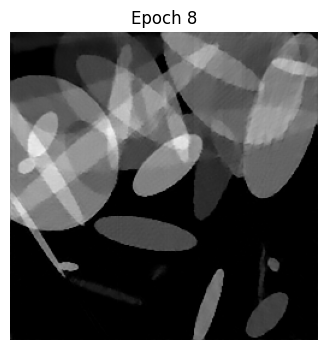

Epoch 08 test  Loss: 0.0007
Epoch 09 train Loss: 0.0007
Best model saved at epoch 9


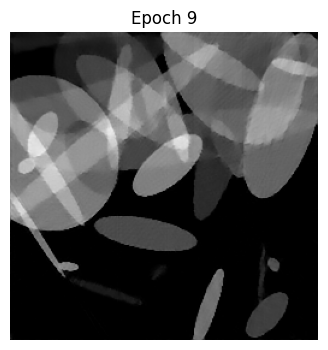

Epoch 09 test  Loss: 0.0007
Epoch 10 train Loss: 0.0007
Best model saved at epoch 10


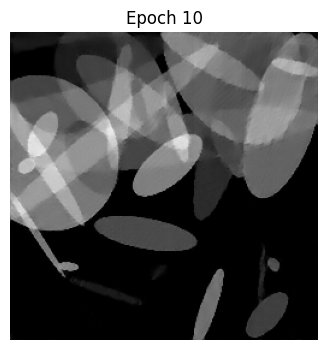

Epoch 10 test  Loss: 0.0006
Epoch 11 train Loss: 0.0006
Best model saved at epoch 11


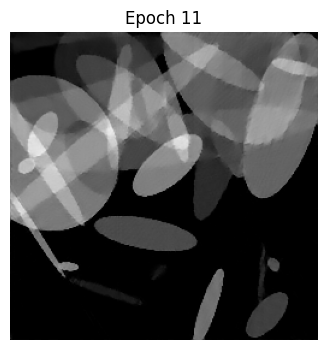

Epoch 11 test  Loss: 0.0006
Epoch 12 train Loss: 0.0006
Best model saved at epoch 12


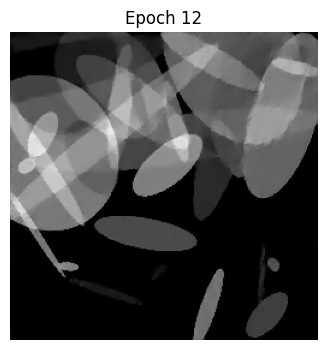

Epoch 12 test  Loss: 0.0006
Epoch 13 train Loss: 0.0006
Best model saved at epoch 13


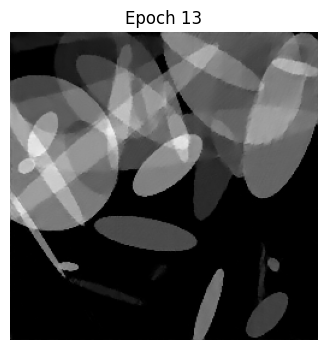

Epoch 13 test  Loss: 0.0006
Epoch 14 train Loss: 0.0006
Best model saved at epoch 14


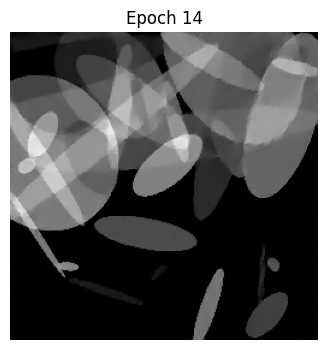

Epoch 14 test  Loss: 0.0005
Epoch 15 train Loss: 0.0005
Best model saved at epoch 15


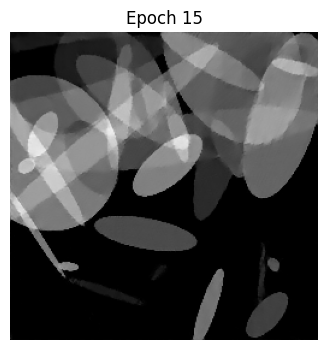

Epoch 15 test  Loss: 0.0005
Epoch 16 train Loss: 0.0005
Best model saved at epoch 16


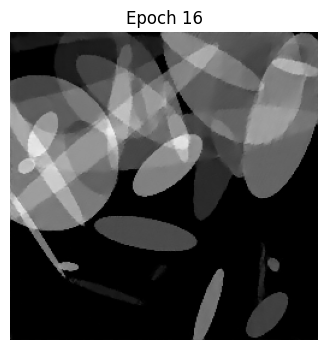

Epoch 16 test  Loss: 0.0005
Epoch 17 train Loss: 0.0005
Best model saved at epoch 17


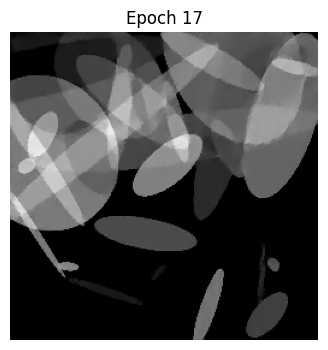

Epoch 17 test  Loss: 0.0005
Epoch 18 train Loss: 0.0005
Best model saved at epoch 18


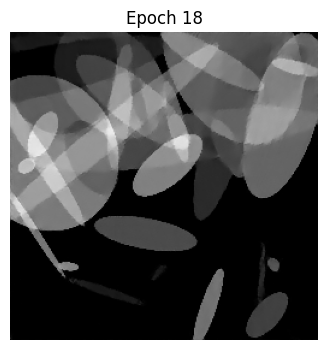

Epoch 18 test  Loss: 0.0005
Epoch 19 train Loss: 0.0005
Best model saved at epoch 19


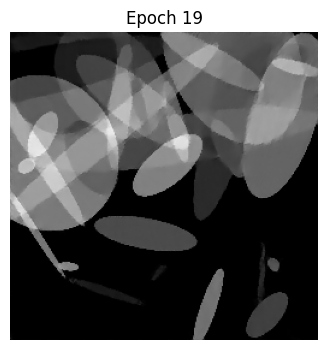

Epoch 19 test  Loss: 0.0005
Epoch 20 train Loss: 0.0005
Best model saved at epoch 20


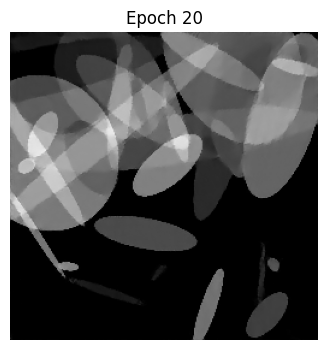

Epoch 20 test  Loss: 0.0005
Epoch 21 train Loss: 0.0005
Best model saved at epoch 21


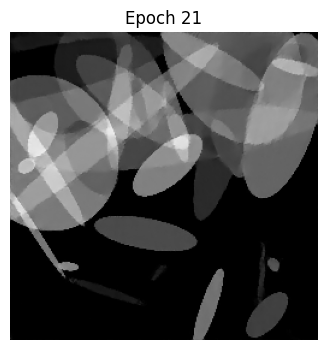

Epoch 21 test  Loss: 0.0004
Epoch 22 train Loss: 0.0004
Best model saved at epoch 22


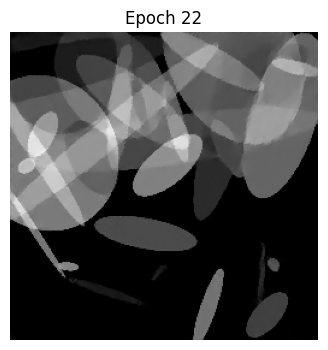

Epoch 22 test  Loss: 0.0004
Epoch 23 train Loss: 0.0004
Best model saved at epoch 23


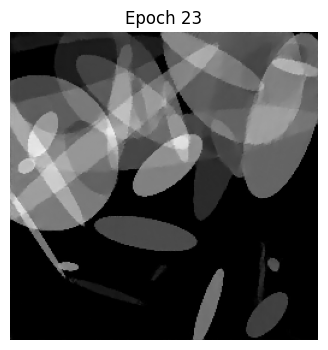

Epoch 23 test  Loss: 0.0004
Epoch 24 train Loss: 0.0004
Best model saved at epoch 24


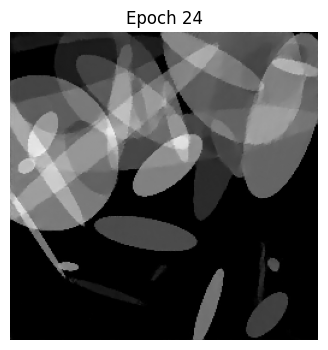

Epoch 24 test  Loss: 0.0004
Epoch 25 train Loss: 0.0004
Best model saved at epoch 25


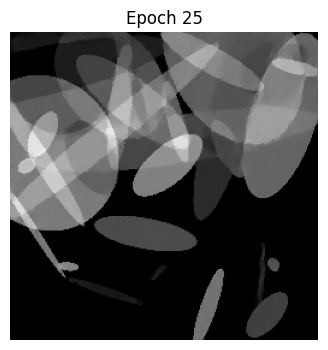

Epoch 25 test  Loss: 0.0004
Epoch 26 train Loss: 0.0004
Best model saved at epoch 26


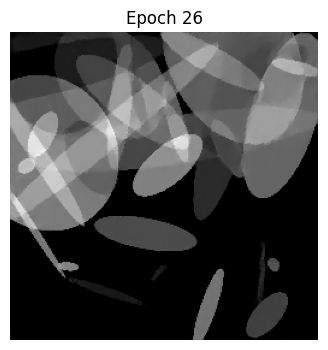

Epoch 26 test  Loss: 0.0004
Epoch 27 train Loss: 0.0004
Best model saved at epoch 27


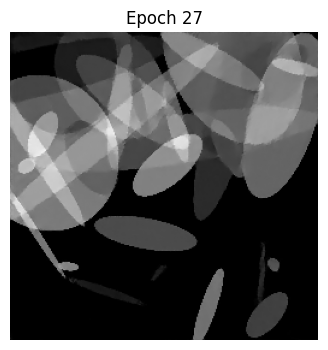

Epoch 27 test  Loss: 0.0004
Epoch 28 train Loss: 0.0004
Best model saved at epoch 28


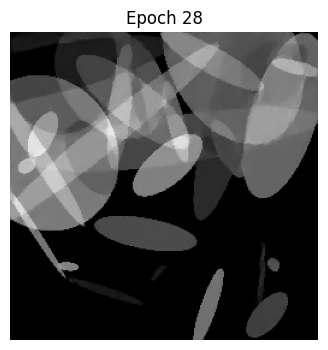

Epoch 28 test  Loss: 0.0004
Epoch 29 train Loss: 0.0004
Best model saved at epoch 29


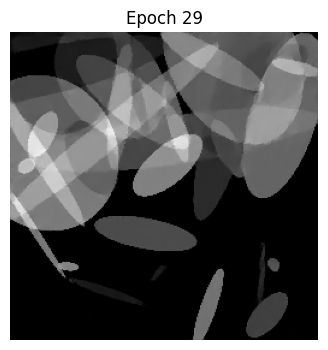

Epoch 29 test  Loss: 0.0004


In [11]:
epochs = 30 
loss_fn = torch.nn.MSELoss()

# Save Weights

os.makedirs('checkpoints', exist_ok=True)
best_test_loss = float('inf')

for epoch in range(epochs):
    pre_model.train()
    running = 0.0
    for x_true in train_loader:              # now x_true is [B,1,256,256]
      x_true = x_true.to(device)
      y = physics(x_true)             # forward project → [B,1,det,angles]
      x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
      y_pred = pre_model(x0)               # refine in image space
      # loss = torch.norm(y_pred - x_true)
      loss = loss_fn(y_pred, x_true)
      loss.backward()
      opt.step()
      opt.zero_grad()
      running += loss.item()
    print(f"Epoch {epoch:02d} train Loss: {running/len(train_loader):.4f}")

    pre_model.eval()
    running_test = 0.0
    with torch.no_grad():
      for x_true in test_loader:              # now x_true is [B,1,256,256]
        x_true = x_true.to(device)
        y = physics(x_true)             # forward project → [B,1,det,angles]
        x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
        y_pred = pre_model(x0)               # refine in image space
        # loss = torch.norm(y_pred - x_true)
        loss = loss_fn(y_pred, x_true)
        running_test += loss.item()
    # y_pred is [B, 1, H, W]; let's grab the first sample and first channel
      if running_test < best_test_loss:
        best_test_loss = running_test
        torch.save(pre_model.state_dict(), 'checkpoints/pre_model.pth')
        print(f"Best model saved at epoch {epoch}")
    img = y_pred[0, 0].detach().cpu().numpy()   # shape (256,256)
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.show()
    print(f"Epoch {epoch:02d} test  Loss: {running_test/len(test_loader):.4f}")


In [17]:
class DiskDistributedEllipsesDataset(EllipsesDataset):
    def __init__(
        self,
        shape: Tuple[int, int] = (128, 128),
        length: int = 3200,
        fixed_seed: int = 1,
        fold: str = "train",
        diameter: float = 0.4745,
        max_n_ellipse: int = 70,
    ):
        super().__init__(
            shape=shape,
            length=length,
            fixed_seed=fixed_seed,
            fold=fold,
            max_n_ellipse=max_n_ellipse,
        )
        self.diameter = diameter

    def _extend_ellipses_data(self, min_length: int) -> None:
        ellipsoids = np.empty((self.max_n_ellipse, 6))
        n_to_generate = max(min_length - len(self.ellipses_data), 0)
        for _ in range(n_to_generate):
            v = self.rng.uniform(-0.4, 1.0, (self.max_n_ellipse,))
            a1 = 0.2 * self.diameter * self.rng.exponential(1.0, (self.max_n_ellipse,))
            a2 = 0.2 * self.diameter * self.rng.exponential(1.0, (self.max_n_ellipse,))
            c_r = self.rng.triangular(
                0.0, self.diameter, self.diameter, size=(self.max_n_ellipse,)
            )
            c_a = self.rng.uniform(0.0, 2 * np.pi, (self.max_n_ellipse,))
            x = np.cos(c_a) * c_r
            y = np.sin(c_a) * c_r
            rot = self.rng.uniform(0.0, 2 * np.pi, (self.max_n_ellipse,))
            n_ellipse = min(self.rng.poisson(self.max_n_ellipse), self.max_n_ellipse)
            v[n_ellipse:] = 0.0
            ellipsoids = np.stack((v, a1, a2, x, y, rot), axis=1)
            self.ellipses_data.append(ellipsoids)


def get_disk_dist_ellipses_dataset(
    fold: str = "train",
    im_size: int = 128,
    length: int = 3200,
    diameter: float = 0.4745,
    max_n_ellipse: int = 70,
    fixed_seed: int = 1,
    device=None,
) -> DiskDistributedEllipsesDataset:
    image_dataset = DiskDistributedEllipsesDataset(
        (im_size, im_size),
        **{"length": length, "fold": fold},
        diameter=diameter,
        max_n_ellipse=max_n_ellipse,
        fixed_seed=fixed_seed
    )

    return image_dataset


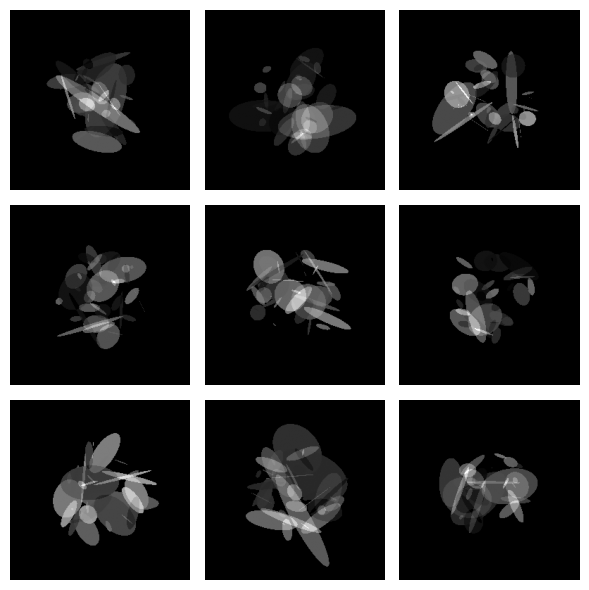

In [18]:
disk_ds = get_disk_dist_ellipses_dataset(fold="train", im_size = 256, length = 5000, diameter = 0.4745, max_n_ellipse = 40)
img = []
for i in range(9):
    img.append(disk_ds[i].squeeze(0).numpy())

fig1, axs1 = plt.subplots(3, 3, figsize=(6,6))
for ax1, im1 in zip(axs1.flat, img):
    ax1.imshow(im1, cmap="gray", vmin=0, vmax=1)
    ax1.axis("off")
plt.tight_layout()
plt.show()

In [19]:
train_disk_ds = get_disk_dist_ellipses_dataset(fold="train", im_size = 256, length = 5000, diameter = 0.4745, max_n_ellipse = 40, fixed_seed = 42)
test_disk_ds  = get_disk_dist_ellipses_dataset(fold="validation", im_size = 256, length = 5000, diameter = 0.4745, max_n_ellipse = 40, fixed_seed = 1)

train_disk_loader = DataLoader(train_disk_ds, batch_size=16)
test_disk_loader  = DataLoader(test_disk_ds,  batch_size=16)

In [20]:
physics = OperatorModule(physics_raw)
disk_pre_model = UNet(1, 1)
disk_model = disk_pre_model.to(device)
opt = torch.optim.Adam(disk_model.parameters(), lr = 1e-4)

Epoch 00 train Loss: 0.0034
Best model saved at epoch 0


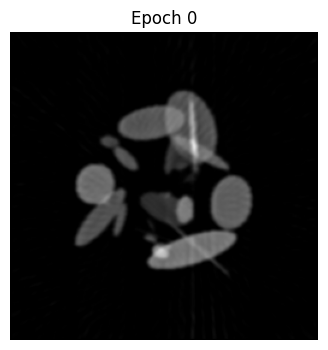

Epoch 00 test  Loss: 0.0042
Epoch 01 train Loss: 0.0007
Best model saved at epoch 1


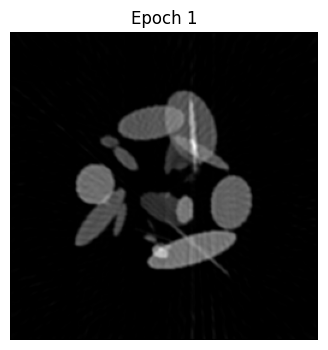

Epoch 01 test  Loss: 0.0032
Epoch 02 train Loss: 0.0006
Best model saved at epoch 2


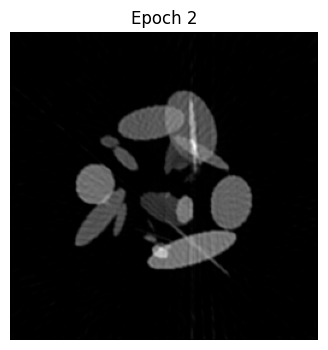

Epoch 02 test  Loss: 0.0027
Epoch 03 train Loss: 0.0005
Best model saved at epoch 3


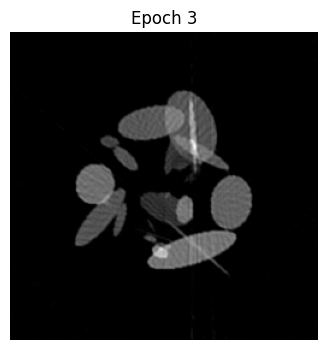

Epoch 03 test  Loss: 0.0024
Epoch 04 train Loss: 0.0005
Best model saved at epoch 4


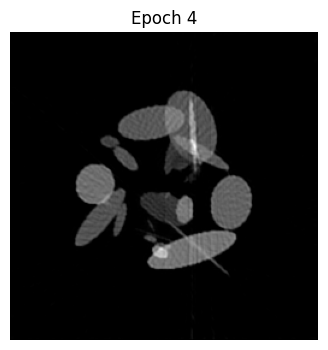

Epoch 04 test  Loss: 0.0022
Epoch 05 train Loss: 0.0004
Best model saved at epoch 5


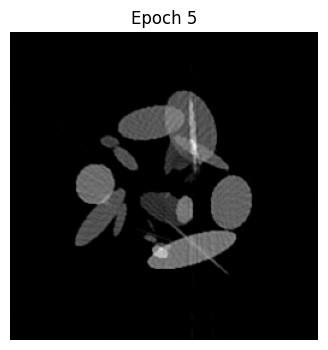

Epoch 05 test  Loss: 0.0020
Epoch 06 train Loss: 0.0004
Best model saved at epoch 6


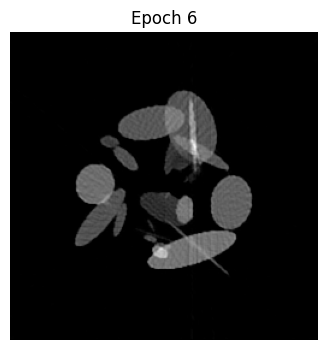

Epoch 06 test  Loss: 0.0018
Epoch 07 train Loss: 0.0004
Best model saved at epoch 7


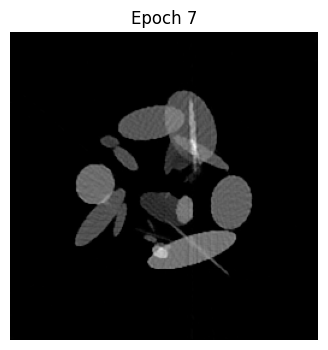

Epoch 07 test  Loss: 0.0017
Epoch 08 train Loss: 0.0003
Best model saved at epoch 8


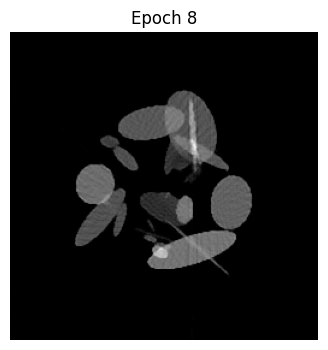

Epoch 08 test  Loss: 0.0015
Epoch 09 train Loss: 0.0003
Best model saved at epoch 9


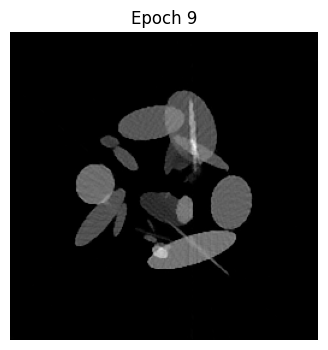

Epoch 09 test  Loss: 0.0014
Epoch 10 train Loss: 0.0003
Best model saved at epoch 10


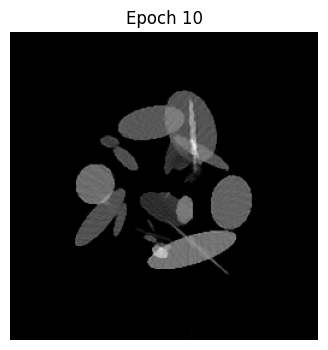

Epoch 10 test  Loss: 0.0013
Epoch 11 train Loss: 0.0003
Best model saved at epoch 11


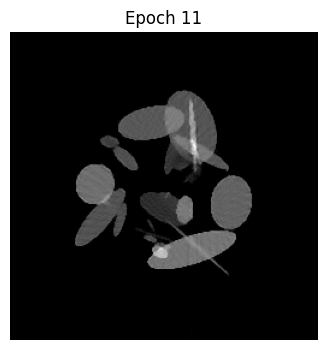

Epoch 11 test  Loss: 0.0012
Epoch 12 train Loss: 0.0002
Best model saved at epoch 12


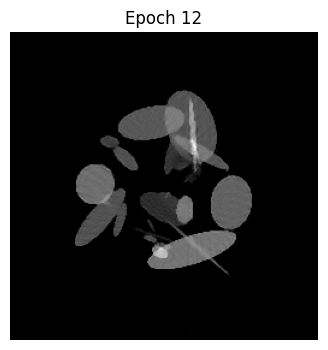

Epoch 12 test  Loss: 0.0012
Epoch 13 train Loss: 0.0002
Best model saved at epoch 13


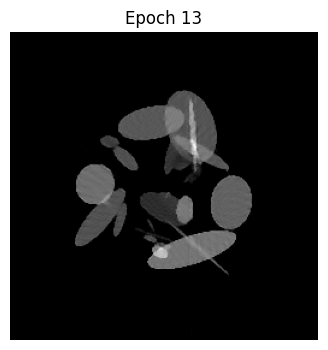

Epoch 13 test  Loss: 0.0011
Epoch 14 train Loss: 0.0002
Best model saved at epoch 14


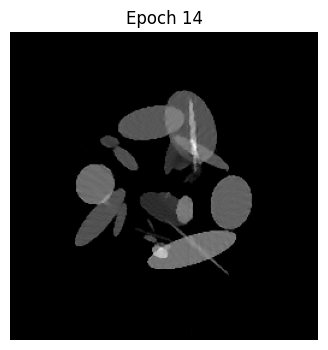

Epoch 14 test  Loss: 0.0011
Epoch 15 train Loss: 0.0002
Best model saved at epoch 15


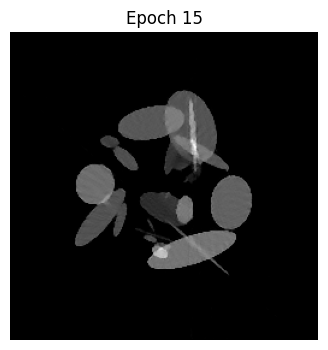

Epoch 15 test  Loss: 0.0010
Epoch 16 train Loss: 0.0002
Best model saved at epoch 16


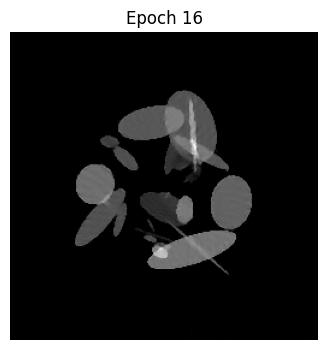

Epoch 16 test  Loss: 0.0010
Epoch 17 train Loss: 0.0002
Best model saved at epoch 17


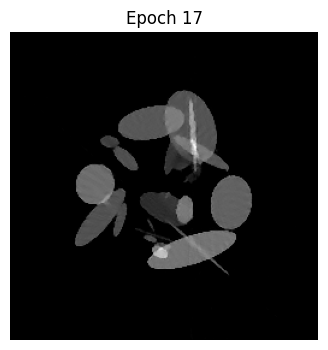

Epoch 17 test  Loss: 0.0010
Epoch 18 train Loss: 0.0002
Best model saved at epoch 18


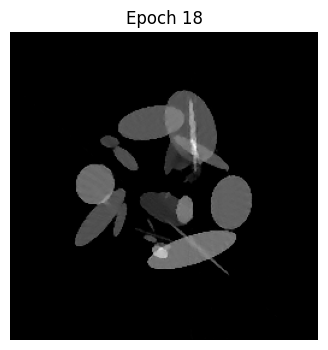

Epoch 18 test  Loss: 0.0009
Epoch 19 train Loss: 0.0002
Best model saved at epoch 19


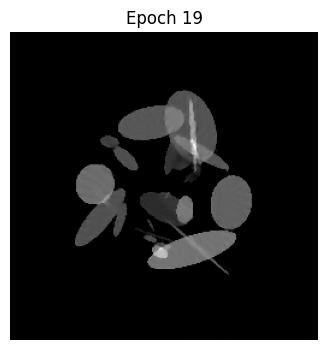

Epoch 19 test  Loss: 0.0009
Epoch 20 train Loss: 0.0002
Best model saved at epoch 20


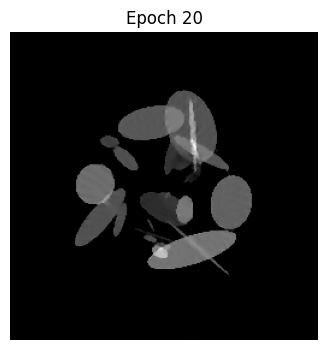

Epoch 20 test  Loss: 0.0009
Epoch 21 train Loss: 0.0002
Best model saved at epoch 21


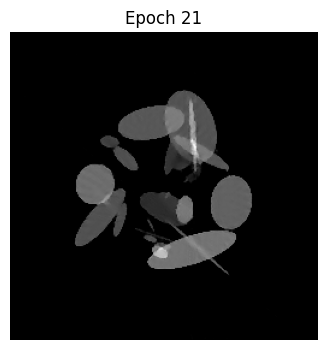

Epoch 21 test  Loss: 0.0008
Epoch 22 train Loss: 0.0002
Best model saved at epoch 22


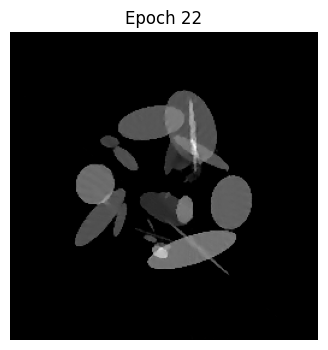

Epoch 22 test  Loss: 0.0008
Epoch 23 train Loss: 0.0002
Best model saved at epoch 23


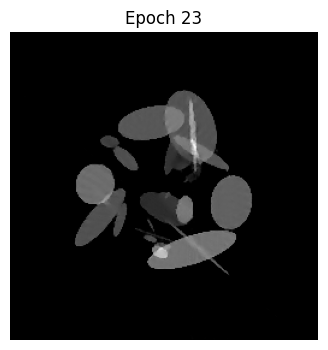

Epoch 23 test  Loss: 0.0008
Epoch 24 train Loss: 0.0002
Best model saved at epoch 24


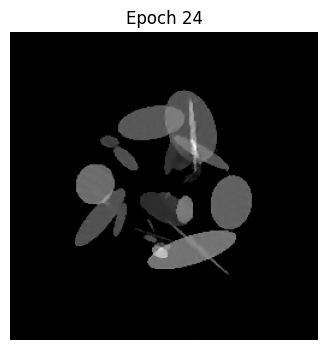

Epoch 24 test  Loss: 0.0008
Epoch 25 train Loss: 0.0002
Best model saved at epoch 25


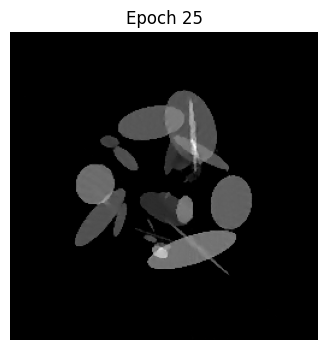

Epoch 25 test  Loss: 0.0008
Epoch 26 train Loss: 0.0002
Best model saved at epoch 26


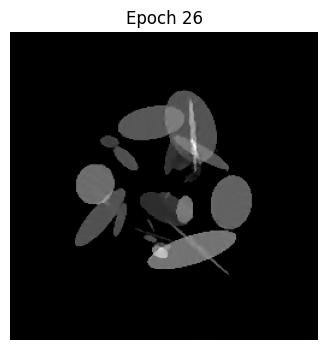

Epoch 26 test  Loss: 0.0007
Epoch 27 train Loss: 0.0001
Best model saved at epoch 27


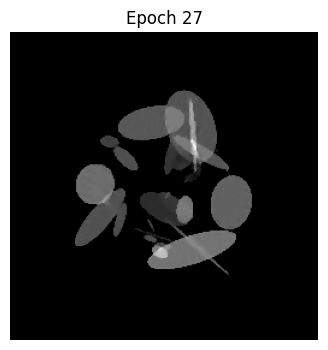

Epoch 27 test  Loss: 0.0007
Epoch 28 train Loss: 0.0001
Best model saved at epoch 28


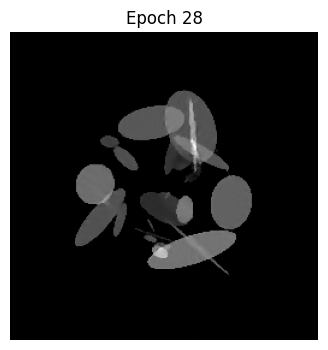

Epoch 28 test  Loss: 0.0007
Epoch 29 train Loss: 0.0001
Best model saved at epoch 29


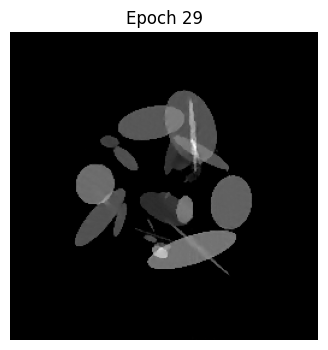

Epoch 29 test  Loss: 0.0007


In [21]:
epochs = 30
loss_fn = torch.nn.MSELoss()

# Save Weights

os.makedirs('checkpoints', exist_ok=True)
best_test_loss = float('inf')

for epoch in range(epochs):
    disk_model.train()
    running = 0.0
    for x_true in train_disk_loader:              # now x_true is [B,1,256,256]
      x_true = x_true.to(device)
      y = physics(x_true)             # forward project → [B,1,det,angles]
      x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
      y_pred = disk_model(x0)               # refine in image space
      # loss = torch.norm(y_pred - x_true)
      loss = loss_fn(y_pred, x_true)
      loss.backward()
      opt.step()
      opt.zero_grad()
      running += loss.item()
    print(f"Epoch {epoch:02d} train Loss: {running/len(train_loader):.4f}")

    disk_model.eval()
    running_test = 0.0
    with torch.no_grad():
      for x_true in test_disk_loader:              # now x_true is [B,1,256,256]
        x_true = x_true.to(device)
        y = physics(x_true)             # forward project → [B,1,det,angles]
        x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
        y_pred = disk_model(x0)               # refine in image space
        # loss = torch.norm(y_pred - x_true)
        loss = loss_fn(y_pred, x_true)
        running_test += loss.item()
    # y_pred is [B, 1, H, W]; let's grab the first sample and first channel
      if running_test < best_test_loss:
        best_test_loss = running_test
        torch.save(pre_model.state_dict(), 'checkpoints/pre_disk_model.pth')
        print(f"Best model saved at epoch {epoch}")
    img = y_pred[0, 0].detach().cpu().numpy()   # shape (256,256)
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.show()
    print(f"Epoch {epoch:02d} test  Loss: {running_test/len(test_loader):.4f}")
